# Streaming models
## Static models
- A pretrained model can be applied to a stream of data.
- We will train a model using _scikit-learn_ and predict in a loop.
- Then try to convert it to a _river_ streaming model before applying it to a stream of data.
- Finally, create a streaming model directly in _river_.

In [1]:
from sklearn import datasets
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

# Load the data
dataset = datasets.load_breast_cancer()
X, y = dataset.data, dataset.target

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Define the steps of the model
model = Pipeline([
    ('scale', preprocessing.StandardScaler()),
    ('log_reg', SGDClassifier(loss="log_loss", penalty="l2")) 
    # (Logistic Regression using Stochastic Gradient Descent to enable .partial_fit())
])

# Ten-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Compute the accuracy
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv)

# Display the average score and it's standard deviation
print(f'Accuracy: {scores.mean():.3f} (± {scores.std():.3f})')

Accuracy: 0.961 (± 0.029)


In [2]:
# Fit the model with all training data
model.fit(X_train, y_train)

,steps,"[('scale', ...), ('log_reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,loss,'log_loss'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15


In [3]:
# Loop over the test data (i.e., stream) and compute the accuracy
acc = 0
for x, y in zip(X_test, y_test):
    acc += model.score(x.reshape(1, -1), y.reshape(1, -1))
print(f'Accuracy: {acc / len(X_test) * 100:.2f}%')

Accuracy: 96.28%


### Converting to _river_

In [4]:
# Extract the mean and standard deviation of each feature
mean = model.named_steps['scale'].mean_
std = model.named_steps['scale'].scale_

# Create a river StandardScaler and insert the mean and variance
from river.preprocessing import StandardScaler
ss = StandardScaler()
ss.vars = dict(zip(dataset.feature_names, std ** 2))
ss.means = dict(zip(dataset.feature_names, mean))

In [5]:
# Wrap the Logistic Regression model
import numpy as np
from river.compat import convert_sklearn_to_river
streaming_model = convert_sklearn_to_river(model.named_steps['log_reg'], classes=np.unique(y_train))

In [6]:
# Predict the test set one sample at a time
from river import metrics
from river import stream
metric = metrics.Accuracy()
for x, y in stream.iter_array(X_test, y_test, feature_names=dataset.feature_names):
    x_scaled = ss.transform_one(x)
    y_pred = streaming_model.predict_one(x_scaled)
    metric.update(y_pred, y)
    # metric = metric.update(y_pred, y) # For river < 0.21
print(metric)

Accuracy: 96.28%


### Direct usage of _river_
- The defaults in scikit-learn's SGDClassifier and river's LogisticRegression are different.
- Pipelines can be made with a parenthesis and a pipe symbol.

In [7]:
# Create a pipeline using the StandardScaler and the Logistic Regression model from river
from river import linear_model

streaming_model = (StandardScaler() | linear_model.LogisticRegression())

In [8]:
# Train the streaming_model with the training data
#dataset_train = dataset
#dataset_train.data = X_train.copy()
#dataset_train.target = y_train.copy()

# Online learning
for x, y in stream.iter_array(X_train, y_train, feature_names=dataset.feature_names):
    streaming_model.learn_one(x,y)

In [9]:
# Predict the test set one sample at a time
metric = metrics.Accuracy()
static_pred = []
for x, y in stream.iter_array(X_test, y_test, feature_names=dataset.feature_names):
    y_pred = streaming_model.predict_one(x)
    static_pred.append(y_pred)
    metric.update(y_pred, y)
print(metric)

Accuracy: 97.34%


```{note}
The training regimes are different, so we cannot expect river and scikit-learn to give exactly the same models.
```

## Dynamic models
- For comparison, we can continue learning during prediction of the test set (given that labels come together with the streaming data).

In [10]:
# Learn and predict the test set one sample at a time
metric = metrics.Accuracy()
dynamic_pred = []
for x, y in stream.iter_array(X_test, y_test, feature_names=dataset.feature_names):
    y_pred = streaming_model.predict_one(x)
    streaming_model.learn_one(x, y)
    dynamic_pred.append(y_pred)
    metric.update(y_pred, y)
print(metric)

Accuracy: 96.81%


__Inspect predictions one by one__

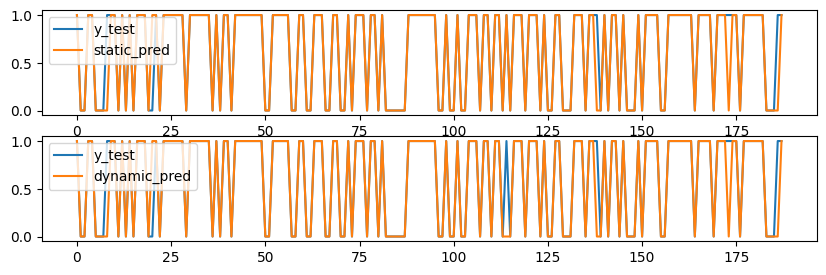

In [11]:
# Plot y_test together with static and dynamic predictions in two plots above each other
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
plt.subplot(2, 1, 1)
plt.plot(y_test, label='y_test')
plt.plot(static_pred, label='static_pred')
plt.legend(loc='upper left')
plt.subplot(2, 1, 2)
plt.plot(y_test, label='y_test')
plt.plot(dynamic_pred, label='dynamic_pred')
plt.legend(loc='upper left')
plt.show()

__Comment:__ In this case, one classification changed to the worse with the dynamic model, the rest stayed the same.

## River vs scikit-learn
- First of all, these are only examples of machine learning frameworks.
    - There are several other established and polished packages to use in their places, e.g., Quix, (scikit-multiflow + creme = River), PyTorch, TensorFlow, theano, PyCaret, OpenCV, etc.
- River is built from the ground up with streaming data in mind.
    - Pre-processors, regressors and classifiers are all incremental.
    - A host of convenience functions for online/batch-wise learning are available.
- scikit-learn is built for tabular data.
    - _.partial\_fit()_ is available for some pre-processors, regressors and classifiers.
    - Stream handling can be manually coded or helped by River and friends.

## Live reading of Twitch chat, revisited
- Requires a free account on [Twitch](https://twitch.tv) and obtaining an [oauth autentication token](https://twitchapps.com/tmi/).
- We will use River's [TwitchChatStream](https://riverml.xyz/0.18.0/api/stream/TwitchChatStream/) to handle the live streamed data.

In [12]:
# Check if user is logged in ("==" active chat)
import requests
user = "cohhcarnage" # Change this to the user you want to check, e.g., epicdan22, zackrawrr, summit1g, mizkif, cohhcarnage, etc.
response = requests.get("https://decapi.me/twitch/uptime/"+user).text
is_online = response != user+" is offline"
print(is_online)

False


In [13]:
# Connect to the Twitch chat using River
from river import stream

oauth = open('../../../No_sync/twitch_oauth','r').read()
twitch_chat = stream.TwitchChatStream(
    nickname="khliland", # Exchange with your Twitch username
    token=oauth,
    channels=[user]
)

In [14]:
# If the user is online, print the first messages
interactive = False  # Set to True if you want to run this
if is_online and interactive:
    messages = 2
    for item in twitch_chat:
        print(item)
        if messages > 1:
            messages -= 1
        else:
            print("Puh, that's enough!")
            break

In [15]:
# Create a river stream that counts the number of characters in the 'msg' part of the 'item' dictionary and plots it
import matplotlib.pyplot as plt
from river.stats import Mean
from IPython import display
import time
messages = 20
i = 0
message_length = [np.nan] * messages
mean_length = [np.nan] * messages
mean = Mean()
if is_online and interactive:
    figure, ax = plt.subplots(figsize=(7,2))
    plt.ion()
    for item in twitch_chat:
        if i < messages:
            message_length[i] = len(item['msg'])
            print(message_length[i])
            mean.update(message_length[i]) # river stats
            mean_length[i] = mean.get()
            plt.clf()
            plt.plot(list(range(messages)), message_length, label='Message length')
            plt.plot(list(range(messages)), mean_length, label='Mean message length')
            plt.xlim(0, messages-1)
            plt.legend(loc='upper right')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            time.sleep(0.0001)
            i += 1
        else:
            print("Puh, that's enough!")
            break
plt.show()


## Synthetic streams
- _river_ can generate synthetic streams of various types.

In [16]:
# Generate Agrawal stream with classification type 0
from river.datasets.synth import Agrawal
dataset = Agrawal(classification_function=0, seed=42)
dataset

Synthetic data generator

    Name  Agrawal              
    Task  Binary classification
 Samples  ∞                    
Features  9                    
 Outputs  1                    
 Classes  2                    
  Sparse  False                

Configuration
-------------
classification_function  0    
                   seed  42   
        balance_classes  False
           perturbation  0.0  

In [17]:
for x, y in dataset.take(5):
    print(list(x.values()), y)

[103125.48379952488, 0, 21, 2, 8, 3, 319768.96426257194, 4, 338349.74371145567] 1
[135983.3438016299, 0, 25, 4, 14, 0, 423837.77555045625, 7, 116330.4466953698] 1
[98262.43477649744, 0, 55, 1, 18, 6, 144088.12440813935, 19, 139095.35411533137] 0
[133009.0417030814, 0, 68, 1, 14, 5, 233361.40250149256, 7, 478606.5361033906] 1
[63757.29086464148, 16955.938253511093, 26, 2, 12, 4, 522851.309309752, 24, 229712.43983592128] 1


## Exercise
- Here, you will be combining elements from various parts of the _river_ documentation.
    - Dataset: Synthetic [Mv dataset](https://riverml.xyz/0.19.0/api/datasets/synth/Mv/), using 20,000 samples.
        - Handle continuous (numbers) and categorical (string) variables in a pipeline (see [example](https://riverml.xyz/0.19.0/api/tree/iSOUPTreeRegressor/)).
        - Continuous response with [$R^2$ metric](https://riverml.xyz/0.19.0/api/metrics/R2/).
    - Model: [HoeffdingTreeRegressor*](https://riverml.xyz/0.19.0/api/tree/HoeffdingTreeRegressor/)
        - Print performance [every 1000 samples](https://riverml.xyz/0.19.0/api/evaluate/iter-progressive-val-score/)
  
 *HoeffdingTreeRegressor: This was originally called a Hoeffding Anytime Tree (HATT). It is an algorithm that is extremely efficient at updating decision trees with streaming data.

## Streaming forecasts
- _river_ includes the SNARIMAX model, where N stands for _non-linear_, i.e., the (S)easonal (N)on-linear (A)uto(R)egressive (I)ntegrated (M)oving-(A)verage with e(X)ogenous inputs model.
- The basic parameters match SARIMAX from the _statsmodels_ package, but are named _p/d/q/sp/sd/sq/m_.
- If no regressor is specified, a pipeline containing a _StandardScaler_ and _LinearRegression_ is used.
- No statistics or summary tables are produced, so summaries must be manually created.

### Airline passenger data
- Monthly international passenger data from January 1949 through December 1960.

In [18]:
from river import datasets
for t, (x, y) in enumerate(datasets.AirlinePassengers()):
    print(x, y)
    if t > 5:
        break

{'month': datetime.datetime(1949, 1, 1, 0, 0)} 112
{'month': datetime.datetime(1949, 2, 1, 0, 0)} 118
{'month': datetime.datetime(1949, 3, 1, 0, 0)} 132
{'month': datetime.datetime(1949, 4, 1, 0, 0)} 129
{'month': datetime.datetime(1949, 5, 1, 0, 0)} 121
{'month': datetime.datetime(1949, 6, 1, 0, 0)} 135
{'month': datetime.datetime(1949, 7, 1, 0, 0)} 148


In [19]:
import datetime as dt
from river import time_series
from river import metrics

#period = 12
model = time_series.SNARIMAX( p=3, d=1, q=3 )

y_test = []
for t, (x, y) in enumerate(datasets.AirlinePassengers()):
    if t > 143-12: # Stop learning before the last 12 months
        y_test.append(y)
    else:
        model.learn_one(y)
        # model = model.learn_one(y)# For river < 0.21

horizon = 12 # Predict 12 months into the future
future = [
    {'month': dt.date(year=1960, month=m, day=1)}
    for m in range(1, horizon + 1)
]
forecast = model.forecast(horizon=horizon)
metric = metrics.R2()
for x, y_pred, y_truth in zip(future, forecast, y_test):
    print(x['month'], f'{y_pred:.3f}', f'{y_truth:.3f}')
    metric.update(y_truth, y_pred)
    # metric = metric.update(y_truth, y_pred).get() # For river < 0.21
print(metric)

1960-01-01 445.159 417.000
1960-02-01 476.332 391.000
1960-03-01 467.187 419.000
1960-04-01 452.182 461.000
1960-05-01 437.547 472.000
1960-06-01 438.079 535.000
1960-07-01 444.407 622.000
1960-08-01 452.582 606.000
1960-09-01 455.664 508.000
1960-10-01 455.428 461.000
1960-11-01 453.501 390.000
1960-12-01 452.975 432.000
R2: -0.254237


### SARIMA + feature engineering
- In addition to the original time series, we may add some freshly calculated exogenous variables.
- In _river_'s SNARIMAX example, a distance function resembling a Radial Basis Function is applied to the months
    - This results in 12 new features measuring the distance to other months in the year.
    - In addition they include ordinal dates, i.e., day number since 0001-01-01.

In [20]:
import calendar
import math
from river import compose
from river import linear_model
from river import optim
from river import preprocessing

def get_month_distances(x):
    return {
        calendar.month_name[month]: math.exp(-(x['month'].month - month) ** 2)
        for month in range(1, 13)
    }

def get_ordinal_date(x):
    return {'ordinal_date': x['month'].toordinal()}

extract_features = compose.TransformerUnion(
    get_ordinal_date,
    get_month_distances
)
extract_features.transform_one({'month': dt.date(year=1960, month=1, day=1)})


{'January': 1.0,
 'February': 0.36787944117144233,
 'March': 0.01831563888873418,
 'April': 0.00012340980408667956,
 'May': 1.1253517471925912e-07,
 'June': 1.3887943864964021e-11,
 'July': 2.3195228302435696e-16,
 'August': 5.242885663363464e-22,
 'September': 1.603810890548638e-28,
 'October': 6.639677199580735e-36,
 'November': 3.720075976020836e-44,
 'December': 2.820770088460135e-53,
 'ordinal_date': 715510}

In [21]:
extract_features.transform_one({'month': dt.date(year=1960, month=4, day=1)})

{'January': 0.00012340980408667956,
 'February': 0.01831563888873418,
 'March': 0.36787944117144233,
 'April': 1.0,
 'May': 0.36787944117144233,
 'June': 0.01831563888873418,
 'July': 0.00012340980408667956,
 'August': 1.1253517471925912e-07,
 'September': 1.3887943864964021e-11,
 'October': 2.3195228302435696e-16,
 'November': 5.242885663363464e-22,
 'December': 1.603810890548638e-28,
 'ordinal_date': 715601}

In [22]:
model = (
    extract_features |
    time_series.SNARIMAX(
        p=1,
        d=0,
        q=0,
        m=12, # Seasonal model with period 12
        sp=3,
        sq=6,
        regressor=(
            preprocessing.StandardScaler() |
            linear_model.LinearRegression(
                intercept_init=110, # Help getting a better start
                optimizer=optim.SGD(0.01),
                intercept_lr=0.3
            )
        )
    )
)

In [23]:
# Modelling and predicting the AirlinePassengers dataset
y_test = []
for t, (x, y) in enumerate(datasets.AirlinePassengers()):
    if t > 143-12: # Stop learning before the last 12 months
        y_test.append(y)
    else:
        model.learn_one(x,y) # Note!: Dates are used as features
        # model = model.learn_one(y)# For river < 0.21

horizon = 12 # Predict 12 months into the future
future = [
    {'month': dt.date(year=1960, month=m, day=1)}
    for m in range(1, horizon + 1)
]
forecast = model.forecast(horizon=horizon)
metric = metrics.R2()
for x, y_pred, y_truth in zip(future, forecast, y_test):
    print(x['month'], f'{y_pred:.3f}', f'{y_truth:.3f}')
    metric.update(y_truth, y_pred)
    # metric = metric.update(y_truth, y_pred).get() # For river < 0.21

print(metric)

1960-01-01 418.156 417.000
1960-02-01 408.071 391.000
1960-03-01 441.154 419.000
1960-04-01 438.874 461.000
1960-05-01 448.431 472.000
1960-06-01 490.385 535.000
1960-07-01 532.368 622.000
1960-08-01 542.568 606.000
1960-09-01 488.254 508.000
1960-10-01 448.343 461.000
1960-11-01 414.920 390.000
1960-12-01 433.052 432.000
R2: 0.743524


```{seealso} 
:class: tip

## Resources
- [scikit-learn's SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [river's iter_array](https://riverml.xyz/dev/api/stream/iter-array/)
- [river's LogisticRegression](https://riverml.xyz/dev/api/linear-model/LogisticRegression/)
- [rivers's Mv dataset](https://riverml.xyz/0.19.0/api/datasets/synth/Mv/)
- [river example of preprocessing in pipeline](https://riverml.xyz/0.19.0/api/tree/iSOUPTreeRegressor/)
- [river's $R^2$ metric](https://riverml.xyz/0.19.0/api/metrics/R2/)
- [river's HoeffdingTreeRegressor](https://riverml.xyz/0.19.0/api/tree/HoeffdingTreeRegressor/)
- [river's iterative progressive validation score](https://riverml.xyz/0.19.0/api/evaluate/iter-progressive-val-score/)
```